# Compose: Training a model to generate music

In [1]:
import os
import pickle
import numpy
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

Using TensorFlow backend.


## Set parameters

In [2]:
# run params
section = 'compose'
run_id = '0006'
music_name = 'cello'

run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', music_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

## Extract the notes

In [3]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

36 files in total
1 Parsing data/cello/cs5-3cou.mid
2 Parsing data/cello/cs6-3cou.mid
3 Parsing data/cello/cs3-4sar.mid
4 Parsing data/cello/cs6-1pre.mid
5 Parsing data/cello/cs4-5bou.mid
6 Parsing data/cello/cs1-5men.mid
7 Parsing data/cello/cs5-5gav.mid
8 Parsing data/cello/cs4-1pre.mid
9 Parsing data/cello/cs6-6gig.mid
10 Parsing data/cello/cs6-2all.mid
11 Parsing data/cello/cs6-5gav.mid
12 Parsing data/cello/cs1-6gig.mid
13 Parsing data/cello/cs1-3cou.mid
14 Parsing data/cello/cs5-4sar.mid
15 Parsing data/cello/cs6-4sar.mid
16 Parsing data/cello/cs5-1pre.mid
17 Parsing data/cello/cs4-4sar.mid
18 Parsing data/cello/cs1-2all.mid
19 Parsing data/cello/cs4-6gig.mid
20 Parsing data/cello/cs1-1pre.mid
21 Parsing data/cello/cs5-6gig.mid
22 Parsing data/cello/cs1-4sar.mid
23 Parsing data/cello/cs2-5men.mid
24 Parsing data/cello/cs2-1pre.mid
25 Parsing data/cello/cs2-3cou.mid
26 Parsing data/cello/cs2-6gig.mid
27 Parsing data/cello/cs2-4sar.mid
28 Parsing data/cello/cs3-6gig.mid
29 Parsing 

## Create the lookup tables

In [4]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [5]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.A3': 1,
 'A2.B2': 2,
 'A2.C3': 3,
 'A2.C3.D3.E3': 4,
 'A2.D3': 5,
 'A2.E-3': 6,
 'A2.E3': 7,
 'A2.E3.A3': 8,
 'A2.E3.C#4': 9,
 'A2.E3.C#4.A4': 10,
 'A2.E3.C#4.E4': 11,
 'A2.E3.C#4.G#4': 12,
 'A2.E3.C4': 13,
 'A2.E3.D4': 14,
 'A2.F#3': 15,
 'A2.F#3.C4': 16,
 'A2.F#3.D4': 17,
 'A2.F#3.D4.A4': 18,
 'A2.F#3.D4.E4': 19,
 'A2.F#3.D4.F#4': 20,
 'A2.F#4': 21,
 'A2.F3': 22,
 'A2.F3.C4': 23,
 'A2.F3.D4': 24,
 'A2.F3.D4.A4': 25,
 'A2.G3': 26,
 'A2.G3.C#4': 27,
 'A2.G3.D4': 28,
 'A3': 29,
 'A3.B-3': 30,
 'A3.B3': 31,
 'A3.B3.A4': 32,
 'A3.B3.C#4': 33,
 'A3.B3.C4': 34,
 'A3.B3.F#4.G4': 35,
 'A3.B3.G4': 36,
 'A3.C#4': 37,
 'A3.C#4.E4': 38,
 'A3.C4': 39,
 'A3.D4': 40,
 'A3.D4.E4': 41,
 'A3.D4.F#4': 42,
 'A3.E4': 43,
 'A3.E4.F#4': 44,
 'A3.E4.F#4.G4': 45,
 'A3.E4.G4': 46,
 'A3.F#4': 47,
 'A3.F#4.G4': 48,
 'A3.F4': 49,
 'A3.G#4.A4': 50,
 'A3.G4': 51,
 'A4': 52,
 'A4.B4': 53,
 'B-2': 54,
 'B-2.A3': 55,
 'B-2.B-3': 56,
 'B-2.D3': 57,
 'B-2.D3.A3': 58,
 'B-2.D3.E-3.G#3': 59,
 'B-2.D3.G#3': 

In [6]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(2, 3): 7,
 0.75: 8,
 1.0: 9,
 1.25: 10,
 Fraction(4, 3): 11,
 1.5: 12,
 1.75: 13,
 2.0: 14,
 2.25: 15,
 2.5: 16,
 3.0: 17,
 4.0: 18}

In [7]:
notes

['START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'START',
 'C3',
 'C2.C3',
 'D3',
 'E-3',
 'F3',
 'G3',
 'G#3',
 'G3',
 'F3',
 'G3',
 'E-3',
 'D2.B2.F3',
 'E-3',
 'E-3',
 'D3',
 'C3',
 'B2',
 'C3',
 'D3',
 'E-2.G2',
 'C3',
 'B2',
 'C3',
 'D3',
 'F3',
 'E-3',
 'D3',
 'C3',
 'F2.C3.G#3',
 'F3',
 'B-3',
 'E-3.C4',
 'G2.D3',
 'G2.G3',
 'C2.G2.E-3',
 'C2.G2.D3',
 'C3',
 'D3',
 'E-3',
 'F3',
 'G3',
 'G#3',
 'C4',
 'B-3',
 'G2.E-3.B-3',
 'G#3',
 'G3',
 'F3',
 'E-3',
 'D3',
 'D3',
 'E-3',
 'A2',
 'F3',
 'E-3',
 'D3',
 'C3',
 'B-2',
 'B-3',
 'C4',
 'B-3',
 'A3',
 'B-3',
 'G3',
 'E-3.C4',
 'B-3',
 'B-3',
 'A3',
 'G3',
 'F#3',
 'G3',
 'A3',
 'D3.G3',
 'F#3',
 'E3',
 'D3',
 'D4',
 'F3.C4',
 'F3.B3',
 'E-3.C4',
 'D3.D4',
 'C3.G3.E-4',
 'D4',

## Prepare the sequences used by the Neural Network

In [8]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [9]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460
 460 460 460 460 460 460 460 460 460 460 460 460 460 460]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Create the structure of the neural network

In [10]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    46100       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    1900        input_2[0][0]                    
____________________________________________________________________________________________

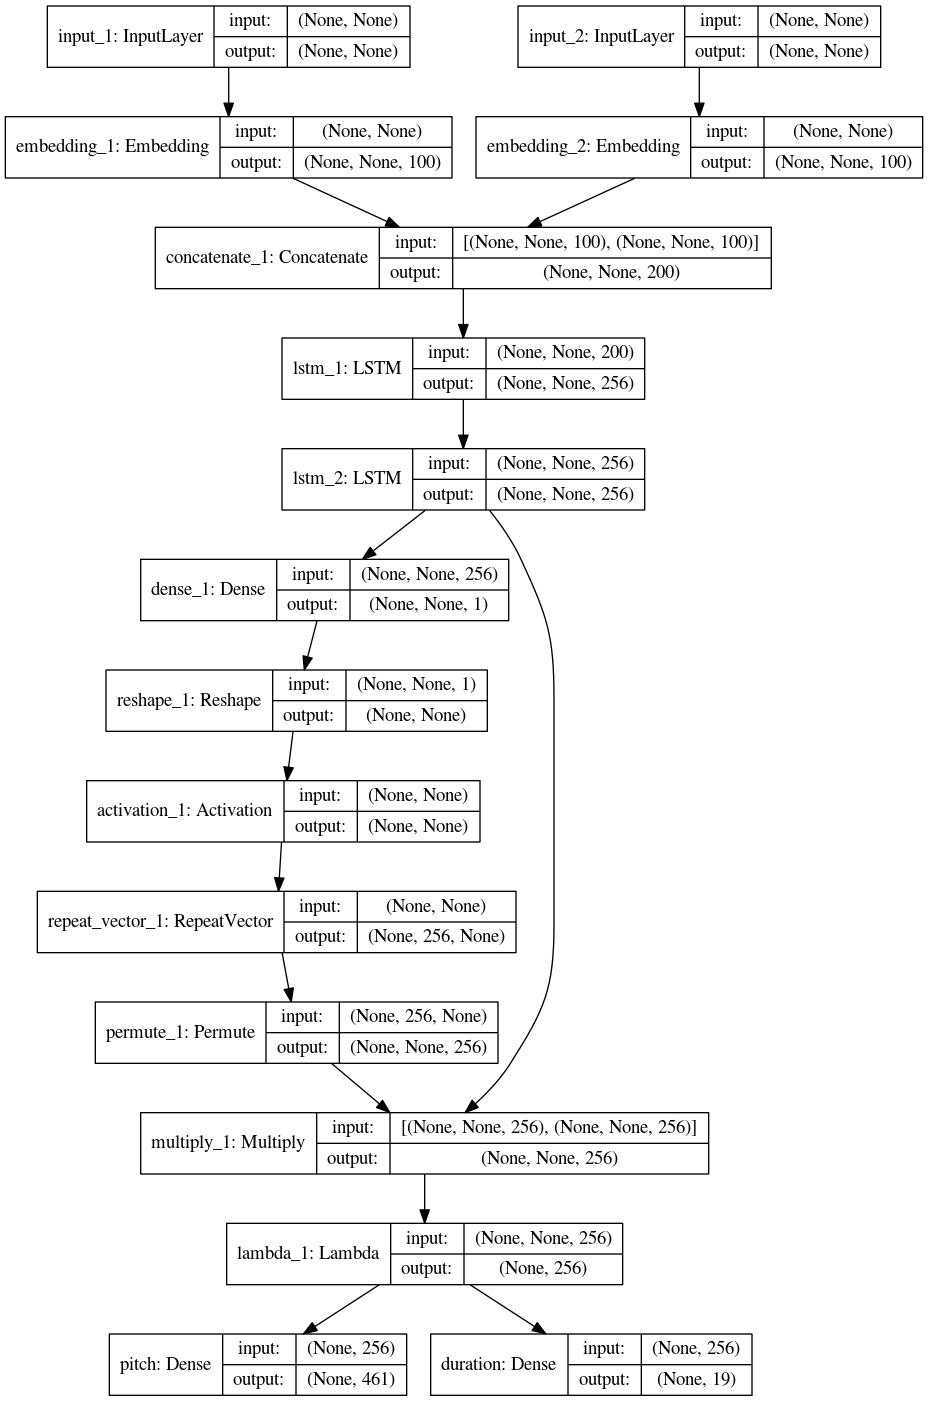

In [11]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [12]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [13]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss', restore_best_weights=True, patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=2000000, batch_size=5120
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

/home/cataluna84/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23024 samples, validate on 5757 samples
Epoch 1/2000000
23024/23024 [==============================] - 3s 141us/step - loss: 8.0524 - pitch_loss: 5.5045 - duration_loss: 2.6262 - val_loss: 6.3028 - val_pitch_loss: 4.4923 - val_duration_loss: 2.3086
Epoch 2/2000000
23024/23024 [==============================] - 2s 76us/step - loss: 5.5395 - pitch_loss: 4.1298 - duration_loss: 1.3729 - val_loss: 4.8974 - val_pitch_loss: 3.7759 - val_duration_loss: 1.5695
Epoch 3/2000000
23024/23024 [==============================] - 2s 76us/step - loss: 5.0984 - pitch_loss: 3.8350 - duration_loss: 1.2601 - val_loss: 4.8677 - val_pitch_loss: 3.7021 - val_duration_loss: 1.7502
Epoch 4/2000000
23024/23024 [==============================] - 2s 75us/step - loss: 4.9771 - pitch_loss: 3.7961 - duration_loss: 1.1807 - val_loss: 4.7168 - val_pitch_loss: 3.7331 - val_duration_loss: 1.3402
Epoch 5/2000000
23024/23024 [==============================] - 2s 77us/step - loss: 4.8475 - pitch_loss: 3.7673 - dura